In [38]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [39]:
#Initialize hyperparameters
#input_size=32*32
no_classes=10
no_epochs=42
batch_size=100
learning_rate=0.01

#initialize seed to have same results
torch.manual_seed(42)
np.random.seed(42)

data_path='dataset/'

In [40]:
class ResnetBlock(nn.Module):
    

    def __init__(self, in_chnls, out_chnls, stride=1):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_chnls, out_chnls, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(out_chnls)
        self.conv2 = nn.Conv2d(out_chnls, out_chnls, kernel_size=3,stride=1, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(out_chnls)

        self.skip = nn.Sequential()
        if stride != 1 or in_chnls != out_chnls:
            self.skip = nn.Sequential(nn.Conv2d(in_chnls, out_chnls,kernel_size=1, stride=stride, bias=False),
                                      nn.BatchNorm2d(out_chnls))
            

    def forward(self, x):
        out = F.relu(self.batchn1(self.conv1(x)))
        out = self.batchn2(self.conv2(out))
        out += self.skip(x)
        out = F.relu(out)
        return out
    
    
    
class Resnet18(nn.Module):
    def __init__(self,in_chnls,no_classes,resnet_block):
        super(Resnet18,self).__init__()
        self.in_chnls=in_chnls
        self.out_chnls=64
        self.conv1 = nn.Conv2d(in_chnls, self.out_chnls, kernel_size=3,stride=1, padding=1, bias=False)
        self.batchn = nn.BatchNorm2d(64)
        self.l1 = self.build_layer(resnet_block, 64, stride=1)
        self.l2 = self.build_layer(resnet_block, 128, stride=2)
        self.l3 = self.build_layer(resnet_block, 256, stride=2)
        self.l4 = self.build_layer(resnet_block, 512, stride=2)
        self.fc=nn.Linear(512,no_classes)
        
    def build_layer(self, block, chnls, stride):
        layers = []
        strides = [stride] + [1]
        
        for stride in strides:
            layers.append(block(self.out_chnls, chnls, stride))
            self.out_chnls = chnls
        return nn.Sequential(*layers)          
              
    
    def forward(self,x):
        #x=self.blocks(x)
        
        
        x=self.conv1(x)
        x=self.batchn(x)
        x = F.relu(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = F.avg_pool2d(x, 4)
        x=x.reshape(x.shape[0],-1)
        x = self.fc(x)
        return x
    
    
          

In [41]:
model = Resnet18(3,10,ResnetBlock)
print(model)

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batchn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Sequential(
    (0): ResnetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (1): ResnetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchn2): BatchNorm2d(64, eps=1e-05, moment

In [42]:
#load data
train_trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset=datasets.CIFAR10(root=data_path,train=True,download=True,transform=train_trans)
test_dataset=datasets.CIFAR10(root=data_path,train=False,download=True,transform=test_trans)


Files already downloaded and verified
Files already downloaded and verified


In [43]:
non_aug_img = datasets.CIFAR10( root='./data/', train=True,download=True)

Files already downloaded and verified


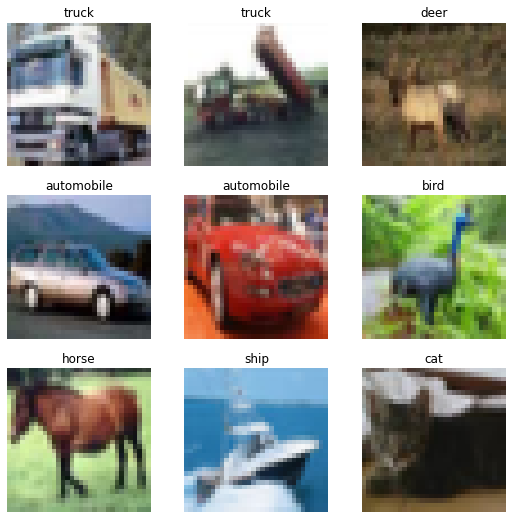

In [44]:
# Visualize some of images

class_labels = {0: 'airplane',1: 'automobile',2: 'bird',
    3: 'cat',4: 'deer',5: 'dog',6: 'frog',    7: 'horse',
    8:'ship',    9: 'truck'}
figure = plt.figure(figsize=(9, 9))
for i in range(1, 10):
    

    figure.add_subplot(3, 3, i)
    plt.title(class_labels[non_aug_img[i][1]])
    plt.imshow(np.asarray(non_aug_img[i][0] ))
    plt.axis("off")
plt.show()

In [45]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
def train_val_dataset(dataset, val_split=0.6):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets



datasets = train_val_dataset(train_dataset)
print(len(datasets['train']))





test_datasets = train_val_dataset(test_dataset,0.6)

print(len(test_datasets['val']))

20000
6000


In [46]:
train_loader=DataLoader(datasets['train'],batch_size,shuffle=True)
test_loader=DataLoader(test_datasets['val'],batch_size,shuffle=True)

In [47]:
#Loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
lrs = []


In [48]:
#Train the network
from tqdm import tqdm
avg_loss=0
correct=0
total=0
avg_losses=[]
accuaracies=[]
for epoch in range(no_epochs):
    losses = []
    loss_epoch=0
    no_correct=0
    no_samples=0
    for data,target in tqdm(train_loader):
        pred=model(data)
        loss=criterion(pred,target)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(data.shape)
        _,ypred=pred.max(1)
        no_correct+=(ypred==target).sum()
        no_samples+=pred.size(0)
        loss_epoch += loss.item()
        
    accu=100.*no_correct/no_samples
    avg_loss = sum(losses) / len(test_loader)
    accuaracies.append(accu)
    avg_losses.append(avg_loss.item())
    lrs.append(optimizer.param_groups[0]["lr"])
    print(f'\nepoch: {epoch+1}, train loss:{avg_loss.item()},accuracy: {accu},lr:{optimizer.param_groups[0]["lr"]}')
    
    
    scheduler.step()


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [10:41<00:00,  3.21s/it]



epoch: 1, train loss:5.768656253814697,accuracy: 36.744998931884766,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:17<00:00,  3.69s/it]



epoch: 2, train loss:4.441653251647949,accuracy: 51.96500015258789,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [17:33<00:00,  5.27s/it]



epoch: 3, train loss:3.6318328380584717,accuracy: 61.255001068115234,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [19:57<00:00,  5.99s/it]



epoch: 4, train loss:3.0596156120300293,accuracy: 67.69499969482422,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:56<00:00,  4.48s/it]



epoch: 5, train loss:2.633422374725342,accuracy: 71.94000244140625,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:43<00:00,  4.12s/it]



epoch: 6, train loss:2.3484015464782715,accuracy: 75.43499755859375,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:28<00:00,  3.74s/it]



epoch: 7, train loss:2.1626462936401367,accuracy: 77.43000030517578,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:56<00:00,  3.88s/it]



epoch: 8, train loss:1.9995709657669067,accuracy: 79.18499755859375,lr:0.01


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:16<00:00,  3.98s/it]



epoch: 9, train loss:1.5610915422439575,accuracy: 83.47000122070312,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:22<00:00,  4.01s/it]



epoch: 10, train loss:1.4141504764556885,accuracy: 85.3949966430664,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:15<00:00,  3.98s/it]



epoch: 11, train loss:1.3553613424301147,accuracy: 85.84500122070312,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:28<00:00,  4.04s/it]



epoch: 12, train loss:1.2740675210952759,accuracy: 86.58000183105469,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:52<00:00,  3.86s/it]



epoch: 13, train loss:1.221070647239685,accuracy: 87.17500305175781,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:00<00:00,  3.60s/it]



epoch: 14, train loss:1.1289942264556885,accuracy: 88.07499694824219,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:24<00:00,  3.42s/it]



epoch: 15, train loss:1.0737401247024536,accuracy: 88.66000366210938,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:47<00:00,  5.04s/it]



epoch: 16, train loss:1.0207324028015137,accuracy: 89.42500305175781,lr:0.005


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [15:11<00:00,  4.56s/it]



epoch: 17, train loss:0.7882619500160217,accuracy: 91.80000305175781,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:01<00:00,  3.91s/it]



epoch: 18, train loss:0.6991900205612183,accuracy: 92.65499877929688,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:23<00:00,  3.72s/it]



epoch: 19, train loss:0.6586400270462036,accuracy: 93.12999725341797,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:29<00:00,  3.45s/it]



epoch: 20, train loss:0.6252058744430542,accuracy: 93.37999725341797,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:15<00:00,  3.38s/it]



epoch: 21, train loss:0.5732752084732056,accuracy: 94.03500366210938,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:14<00:00,  3.37s/it]



epoch: 22, train loss:0.5610529184341431,accuracy: 94.22000122070312,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:48<00:00,  3.84s/it]



epoch: 23, train loss:0.5196738839149475,accuracy: 94.53500366210938,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:54<00:00,  4.47s/it]



epoch: 24, train loss:0.48731115460395813,accuracy: 94.9000015258789,lr:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [17:08<00:00,  5.14s/it]



epoch: 25, train loss:0.3742753565311432,accuracy: 96.37000274658203,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:12<00:00,  4.86s/it]



epoch: 26, train loss:0.3284617066383362,accuracy: 96.7699966430664,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [17:17<00:00,  5.19s/it]



epoch: 27, train loss:0.31619545817375183,accuracy: 96.97000122070312,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:41<00:00,  4.41s/it]



epoch: 28, train loss:0.29085296392440796,accuracy: 97.1449966430664,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:41<00:00,  4.41s/it]



epoch: 29, train loss:0.2731923758983612,accuracy: 97.33499908447266,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:05<00:00,  3.93s/it]



epoch: 30, train loss:0.25328221917152405,accuracy: 97.53500366210938,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:37<00:00,  4.09s/it]



epoch: 31, train loss:0.2378687560558319,accuracy: 97.67500305175781,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:39<00:00,  4.10s/it]



epoch: 32, train loss:0.21965144574642181,accuracy: 97.9000015258789,lr:0.00125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:00<00:00,  4.20s/it]



epoch: 33, train loss:0.19328553974628448,accuracy: 98.28500366210938,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:18<00:00,  4.29s/it]



epoch: 34, train loss:0.1686541736125946,accuracy: 98.55500030517578,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:35<00:00,  4.38s/it]



epoch: 35, train loss:0.1619386523962021,accuracy: 98.53500366210938,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:17<00:00,  3.99s/it]



epoch: 36, train loss:0.15064044296741486,accuracy: 98.69000244140625,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:53<00:00,  3.87s/it]



epoch: 37, train loss:0.14571470022201538,accuracy: 98.7750015258789,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [13:35<00:00,  4.08s/it]



epoch: 38, train loss:0.13357815146446228,accuracy: 98.91500091552734,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:08<00:00,  4.24s/it]



epoch: 39, train loss:0.12954948842525482,accuracy: 98.91500091552734,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [19:24<00:00,  5.82s/it]



epoch: 40, train loss:0.12893329560756683,accuracy: 98.93000030517578,lr:0.000625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:29<00:00,  4.95s/it]



epoch: 41, train loss:0.11281521618366241,accuracy: 99.12000274658203,lr:0.0003125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:34<00:00,  4.37s/it]


epoch: 42, train loss:0.11043426394462585,accuracy: 99.12000274658203,lr:0.0003125


In [52]:
PATH = './cifar_net87.pth'
torch.save(model.state_dict(), PATH)

No handles with labels found to put in legend.


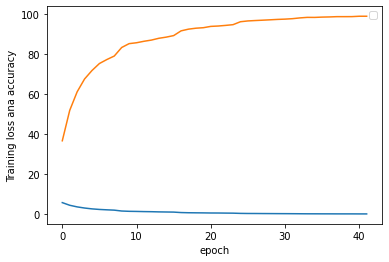

In [49]:
plt.plot(avg_losses)
plt.plot(accuaracies)
plt.xlabel('epoch')
plt.ylabel('Training loss ana accuracy')
plt.legend()

In [50]:
#Check the accuracy
def check_accuracy(DataLoader,model):
    no_correct=0
    no_samples=0
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(DataLoader):
            prediction=model(data)
            _,pred=prediction.max(1)
            no_correct+=(pred==target).sum()
            no_samples+=pred.size(0)
        print(f'accuracy={no_correct/no_samples}')
    model.train()

In [51]:
check_accuracy(test_loader,model)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:18<00:00,  1.31s/it]

accuracy=0.8741666674613953


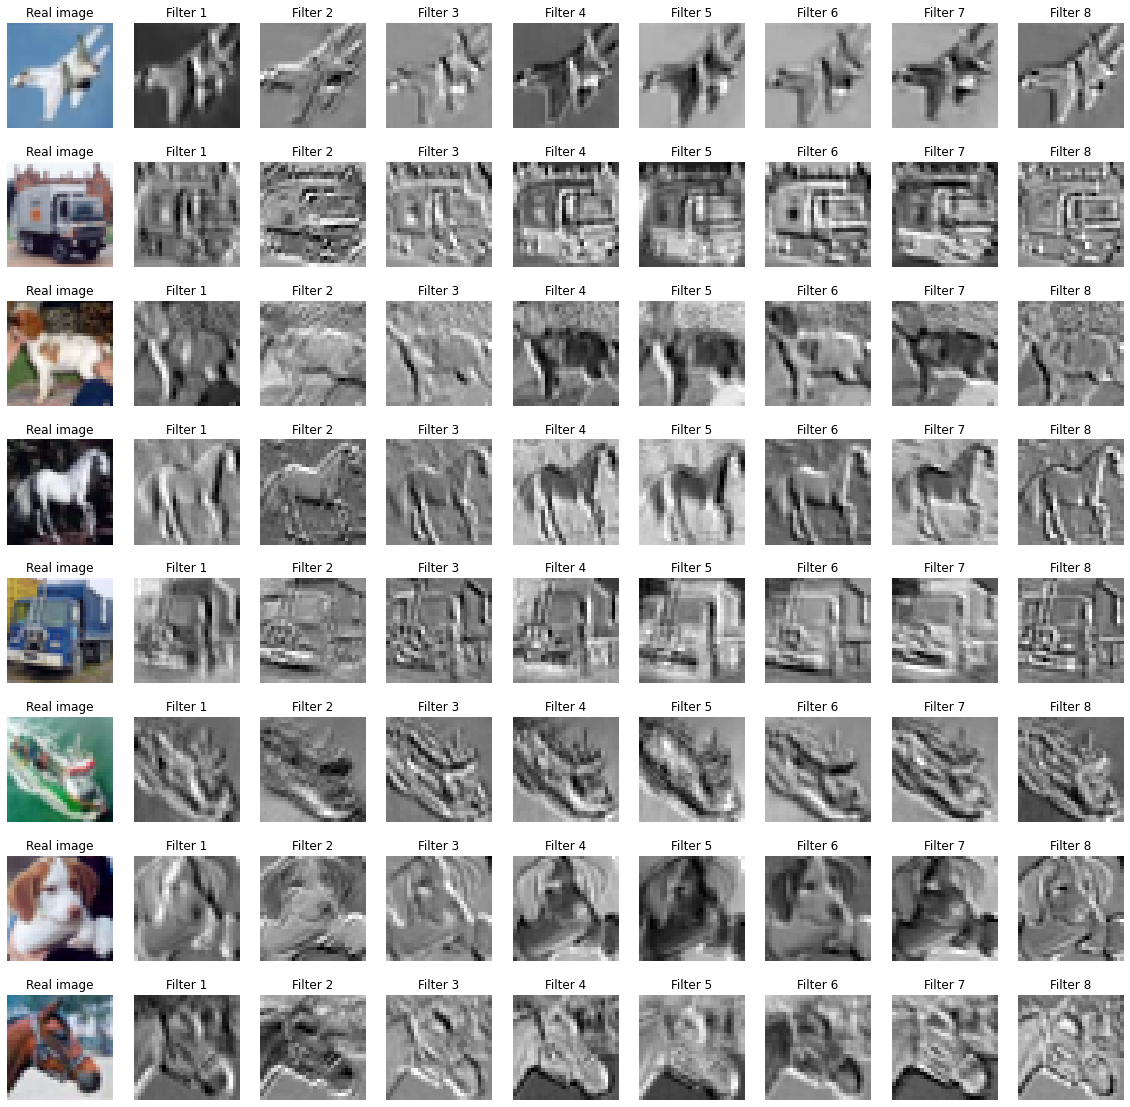

In [53]:
fig = plt.figure(figsize=(20, 20))
imgs = [image for image, label in [test_dataset[i+10] for i in range(8)]]
conv_filters = model.conv1.weight.data[:8]

def norm(img):
    img.clamp_(min=img.min(), max=img.max())
    img.add_(-img.min()).div_(img.max() - img.min() + 1e-8)
    return img

images = torch.cat([img.unsqueeze(0) for img in imgs], dim=0)

no_image = images.shape[0]
no_filter = conv_filters.shape[0]

f_images = F.conv2d(images, conv_filters)


for j in range(no_image):
 

    image=norm(images[j])

    axs = fig.add_subplot(no_image, no_filter+1, j+1+(j*no_filter))
    axs.axis('off')
    axs.set_title('Real image')
    axs.imshow(image.permute(1, 2, 0).numpy())

    for k in range(no_filter):

        image=norm(f_images[j][k])
        axs = fig.add_subplot(no_image, no_filter+1, j+1+(j*no_filter)+k+1)
        axs.imshow(image.numpy(), cmap='gray')
        axs.axis('off')
        axs.set_title(f'Filter {k+1}')
        

In [54]:

def get_pred(model, dataloader):

    preds = []
    lbls = []
    model.eval()
    with torch.no_grad():

        for img, lbl in dataloader:
            lbls.append(lbl)
            pred = model(img)
            preds.append(pred)
            
    preds = torch.cat(preds, dim=0)
    lbls = torch.cat(lbls, dim=0)

    return preds, lbls

outputs, labels =  get_pred(model, test_loader)

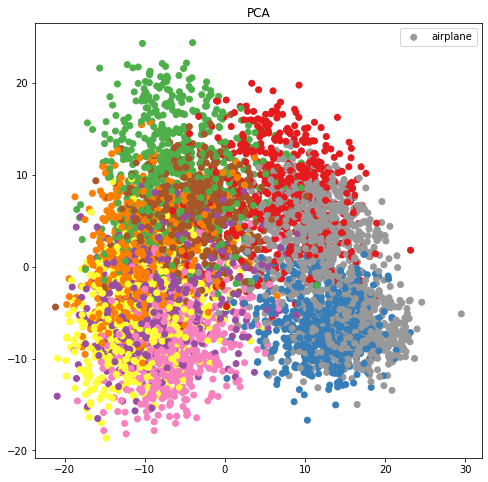

In [56]:
pca = PCA(n_components=2)
out_pca = pca.fit_transform(outputs)

classes = test_dataset.classes
fig = plt.figure(figsize=(8, 8))

scatter = plt.scatter(out_pca[:, 0],out_pca[:, 1], c=labels,cmap='Set1')

plt.legend( labels=classes)
plt.title('PCA')
plt.show()

In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2)
tsne_out = tsne.fit_transform(outputs)
fig = plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_out[:, 0],tsne_out[:, 1], c=labels,cmap='Set1')
plt.legend( labels=classes)
plt.title('TSNE')
plt.show()

In [58]:

def get_pred_softmax(model, dataloader):
    model.eval()
    preds = []
    lbls = []
    model.eval()
    with torch.no_grad():

        for img, lbl in dataloader:
            lbls.append(lbl)
            pred = model(img)
            pred = F.softmax(pred, dim=-1)
            preds.append(pred)
            
    preds = torch.cat(preds, dim=0)
    lbls = torch.cat(lbls, dim=0)

    return preds, lbls




In [59]:
preds, labels = get_pred_softmax(model, test_loader)

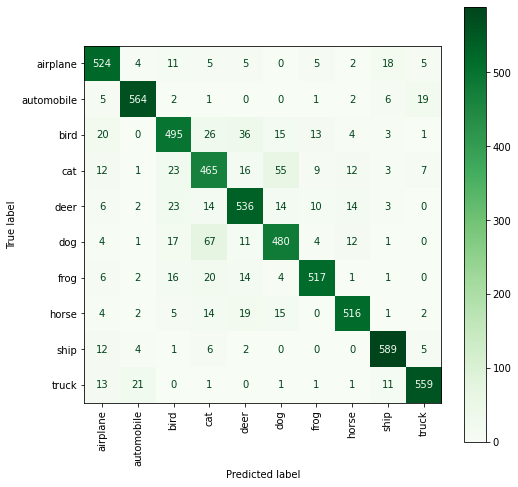

In [60]:

pred_labels = torch.argmax(preds, 1)

cm = confusion_matrix(labels, pred_labels)
cm = ConfusionMatrixDisplay(cm, display_labels=classes)
fig = plt.figure(figsize=(8, 8))
ax= plt.subplot()
cm.plot(values_format='d', cmap='Greens', ax=ax)
plt.xticks(rotation=90)
plt.show()